## Trajectory Prediction by Interpolation
This notebook can be used to interpolate the missing values in the trajectory data. This is only useful when the missing values are not to many and, they are not too close to each other. First we use polynomial interpolation to fill the missing values. Then we use KNN imputation to fill the remaining missing values. The data is then saved to a csv file.
The interpolation is done for each pair of 'u' and 'v' coordinates separately because it gives a more accurate result.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.impute import KNNImputer

Give the path to the file containing the data to interpolate and the path to the file where the interpolated data will be saved.

In [2]:
red_ball_data_to_interpolate = pd.read_csv('../data-9-cams/red_ball_coordinates_128px_2024-03-19_15h25m.csv', decimal='.', delimiter=',')
output_file = '../data-12-cams/red_ball_coordinates_128px_2024-03-20_09h51m_interpolated.csv'
save_output_file = False
num_cameras = 9

In [3]:
red_ball_data_to_interpolate

,u0,v0,u1,v1,u2,v2,u3,v3,u4,v4,u5,v5,u6,v6,u7,v7,u8,v8
0,16.0,52.5,79.0,53.5,16.0,66.0,60.5,66.0,103.5,66.0,16.0,80.0,103.0,79.5,103.0,53.0,79.0,79.0
1,15.0,53.0,78.5,53.5,14.0,67.0,59.0,67.0,102.0,67.0,15.0,81.0,102.0,80.0,102.0,53.5,78.5,79.5
2,13.0,54.0,77.0,55.0,13.0,68.0,58.0,68.0,100.0,68.0,13.0,82.0,100.5,81.5,100.5,54.0,76.5,80.0
3,12.0,54.0,76.0,55.0,11.5,69.0,56.0,68.0,99.0,68.0,12.0,83.0,99.0,81.5,99.0,55.0,76.0,81.0
4,10.0,55.0,75.0,56.0,10.5,69.0,56.0,69.5,98.0,69.0,10.0,83.0,98.0,82.0,98.0,56.0,74.5,81.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808,26.0,47.0,88.0,48.0,26.0,61.0,68.5,60.5,113.0,61.0,26.0,74.0,113.0,75.0,113.5,46.5,88.0,73.5
809,25.0,47.0,87.0,47.0,25.0,60.0,68.0,60.0,113.0,60.0,25.5,73.5,112.0,74.0,112.0,46.0,88.0,73.0
810,24.0,46.0,86.5,46.5,24.0,59.0,67.0,60.0,111.0,59.0,24.0,72.0,111.0,73.0,111.0,45.0,86.5,72.5
811,21.5,44.5,85.0,45.0,21.5,58.0,65.0,58.5,110.0,58.0,22.0,71.0,109.0,71.0,109.5,44.0,85.0,71.0


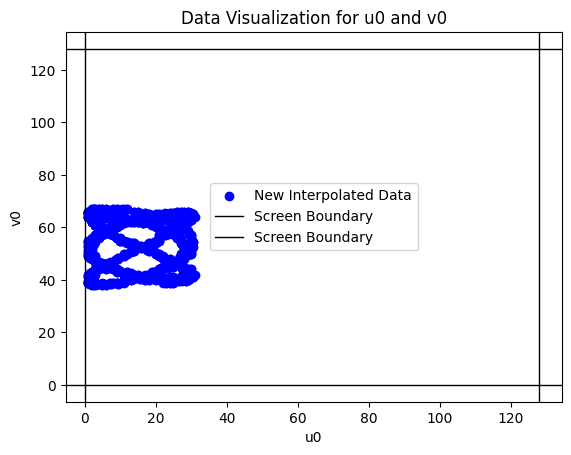

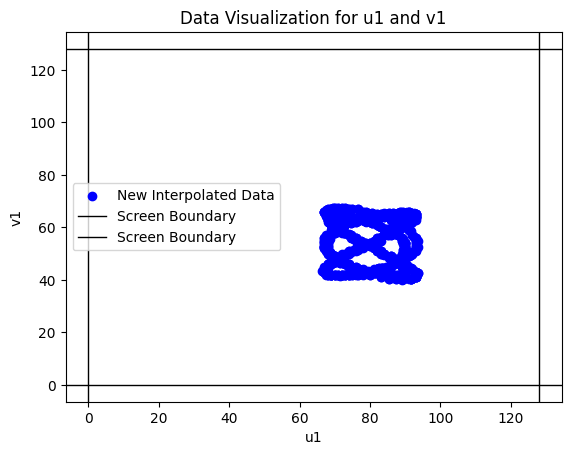

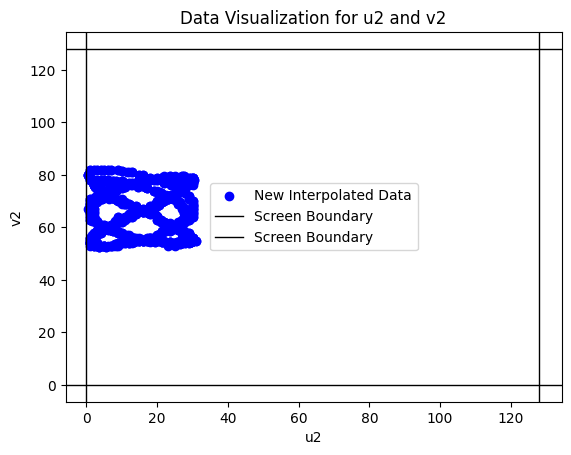

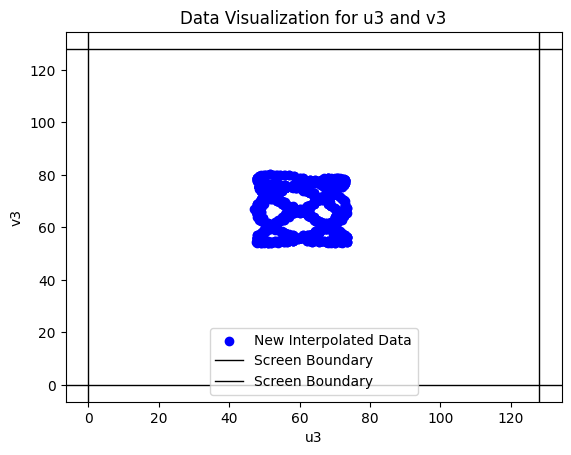

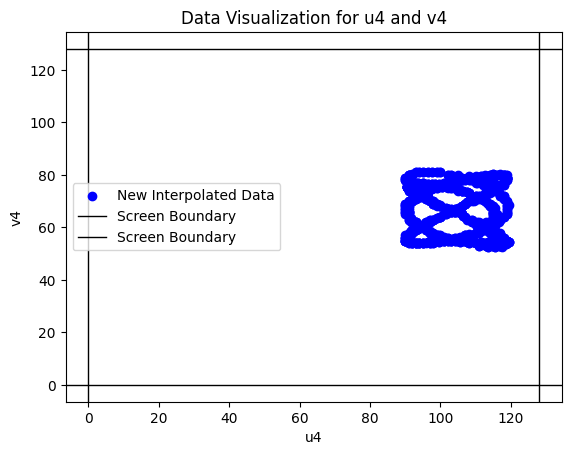

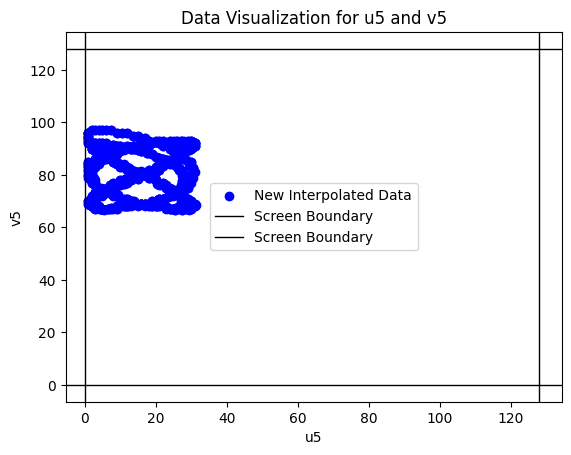

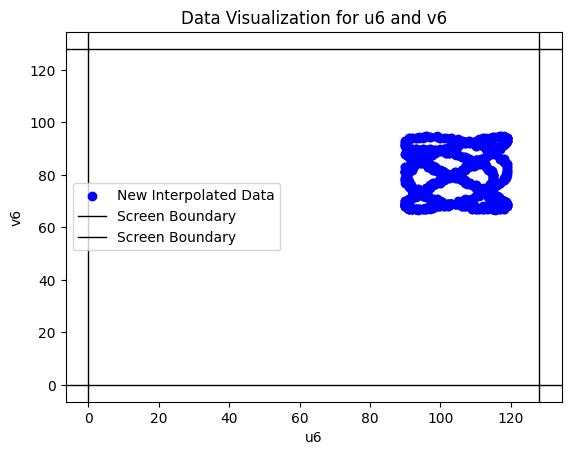

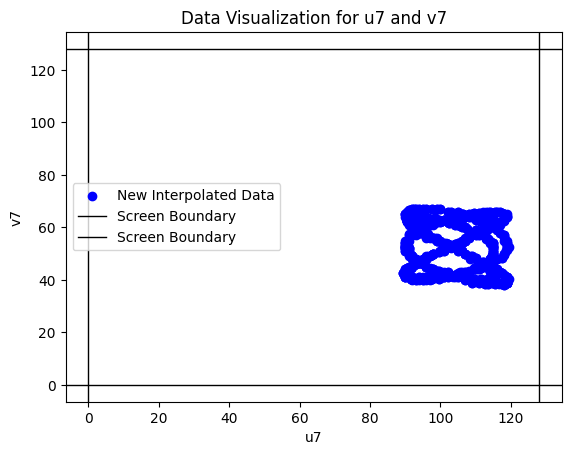

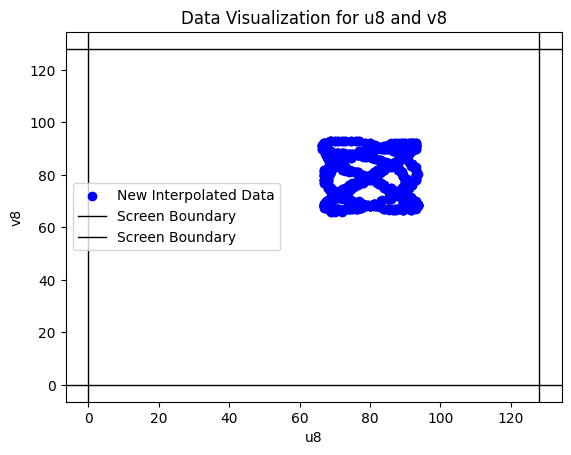

In [4]:
for i in range(num_cameras):
    col_u = f'u{i}'
    col_v = f'v{i}'
    plt.scatter(red_ball_data_to_interpolate[col_u], red_ball_data_to_interpolate[col_v], color='blue', marker='o', label='New Interpolated Data')
    plt.axvline(x=128, color='black', linewidth=1, label='Screen Boundary')
    plt.axhline(y=128, color='black', linewidth=1)
    plt.axvline(x=0, color='black', linewidth=1, label='Screen Boundary')
    plt.axhline(y=0, color='black', linewidth=1)
    plt.title(f'Data Visualization for {col_u} and {col_v}')
    plt.xlabel(col_u)
    plt.ylabel(col_v)
    plt.legend()
    plt.show()

The number of NaN values in u0 before interpolation is 0
The number of NaN values in u0 after interpolation is 0
The number of NaN values in u0 after KNN imputation is 0


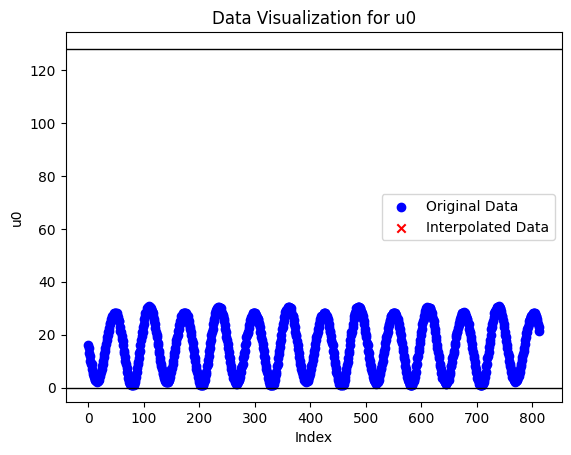

The number of NaN values in v0 before interpolation is 0
The number of NaN values in v0 after interpolation is 0
The number of NaN values in v0 after KNN imputation is 0


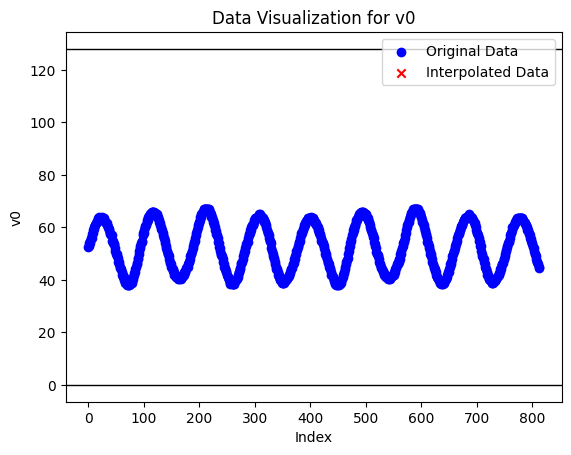

The number of NaN values in u1 before interpolation is 0
The number of NaN values in u1 after interpolation is 0
The number of NaN values in u1 after KNN imputation is 0


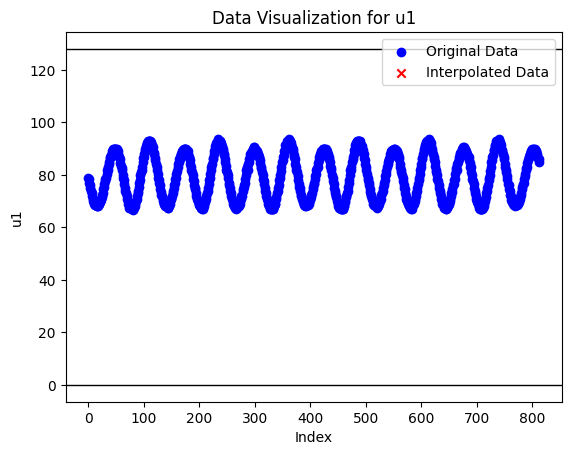

The number of NaN values in v1 before interpolation is 0
The number of NaN values in v1 after interpolation is 0
The number of NaN values in v1 after KNN imputation is 0


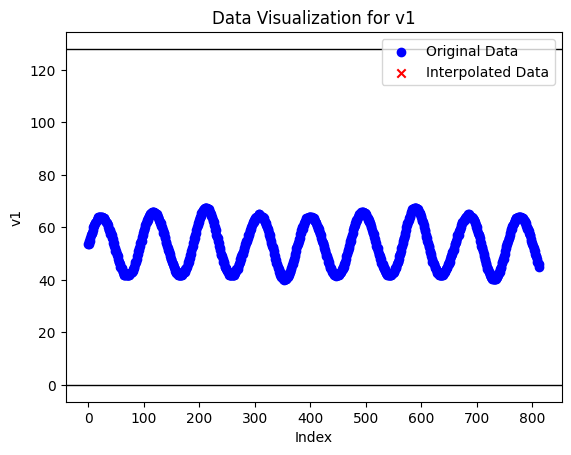

The number of NaN values in u2 before interpolation is 0
The number of NaN values in u2 after interpolation is 0
The number of NaN values in u2 after KNN imputation is 0


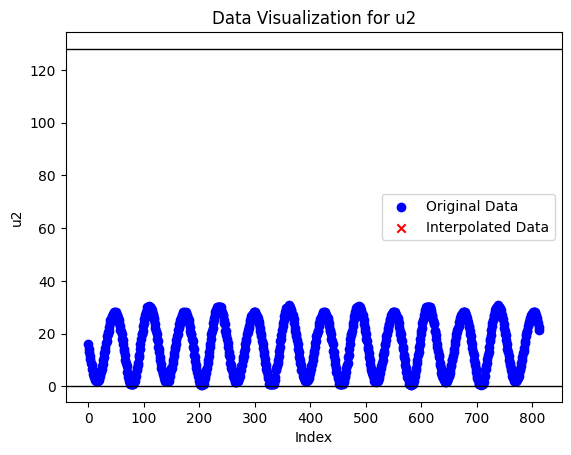

The number of NaN values in v2 before interpolation is 0
The number of NaN values in v2 after interpolation is 0
The number of NaN values in v2 after KNN imputation is 0


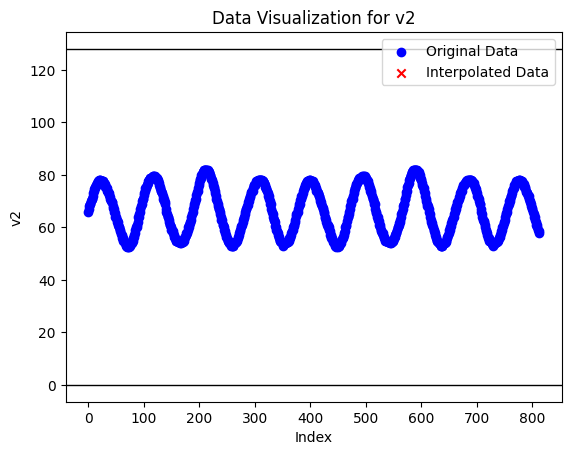

The number of NaN values in u3 before interpolation is 1
The number of NaN values in u3 after interpolation is 0
The number of NaN values in u3 after KNN imputation is 0


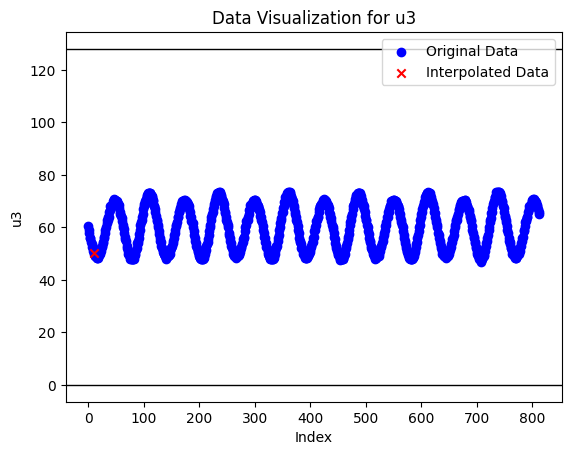

The number of NaN values in v3 before interpolation is 1
The number of NaN values in v3 after interpolation is 0
The number of NaN values in v3 after KNN imputation is 0


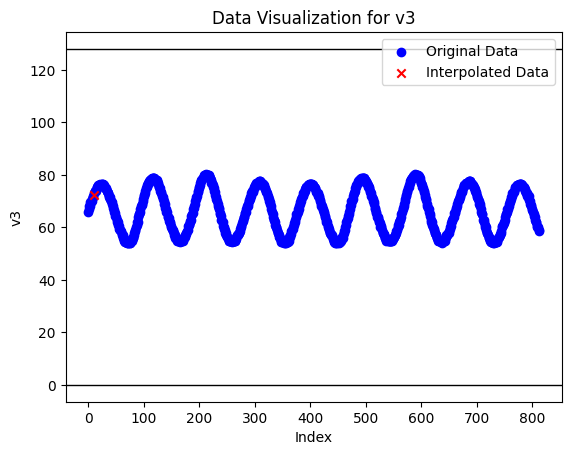

The number of NaN values in u4 before interpolation is 0
The number of NaN values in u4 after interpolation is 0
The number of NaN values in u4 after KNN imputation is 0


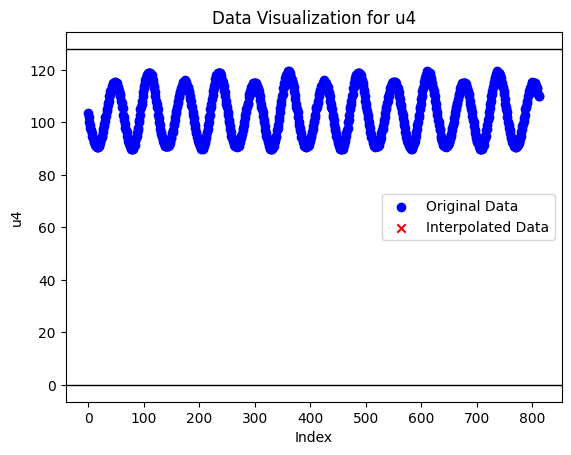

The number of NaN values in v4 before interpolation is 0
The number of NaN values in v4 after interpolation is 0
The number of NaN values in v4 after KNN imputation is 0


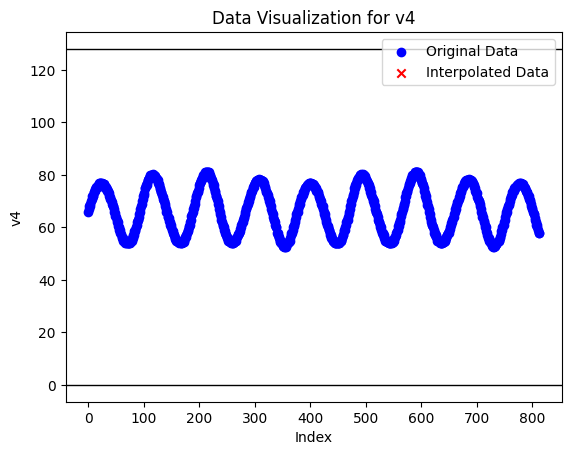

The number of NaN values in u5 before interpolation is 0
The number of NaN values in u5 after interpolation is 0
The number of NaN values in u5 after KNN imputation is 0


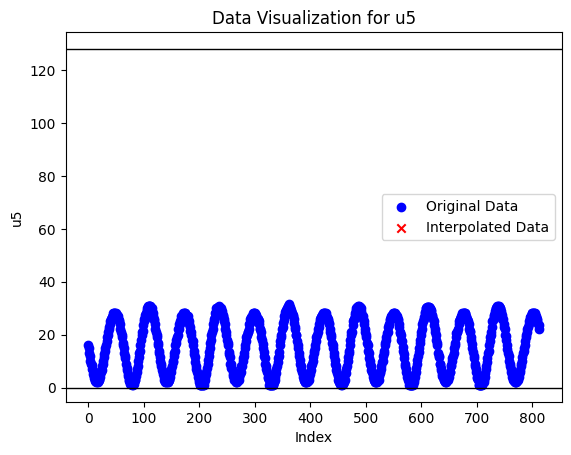

The number of NaN values in v5 before interpolation is 0
The number of NaN values in v5 after interpolation is 0
The number of NaN values in v5 after KNN imputation is 0


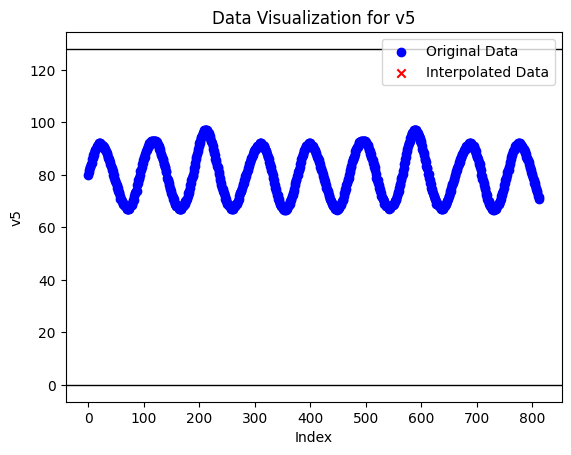

The number of NaN values in u6 before interpolation is 0
The number of NaN values in u6 after interpolation is 0
The number of NaN values in u6 after KNN imputation is 0


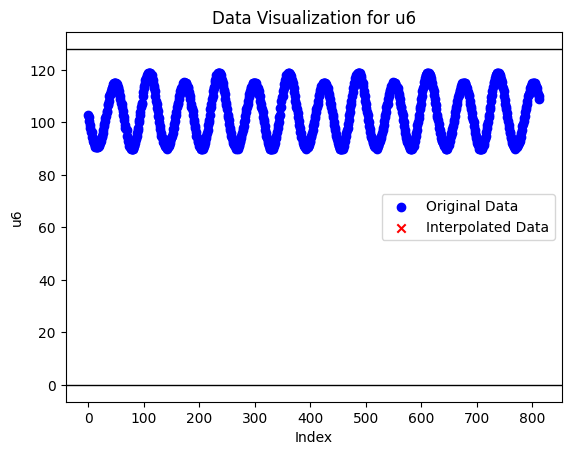

The number of NaN values in v6 before interpolation is 0
The number of NaN values in v6 after interpolation is 0
The number of NaN values in v6 after KNN imputation is 0


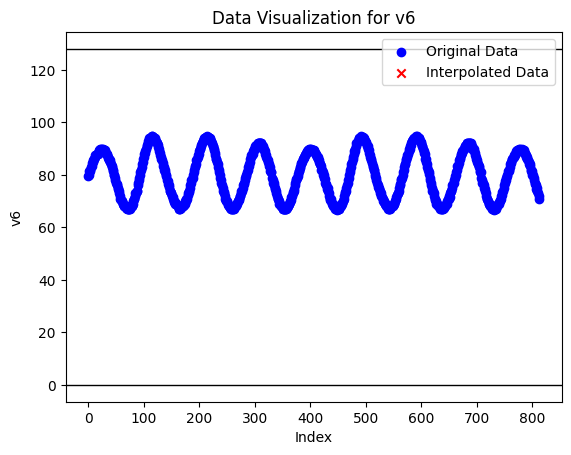

The number of NaN values in u7 before interpolation is 0
The number of NaN values in u7 after interpolation is 0
The number of NaN values in u7 after KNN imputation is 0


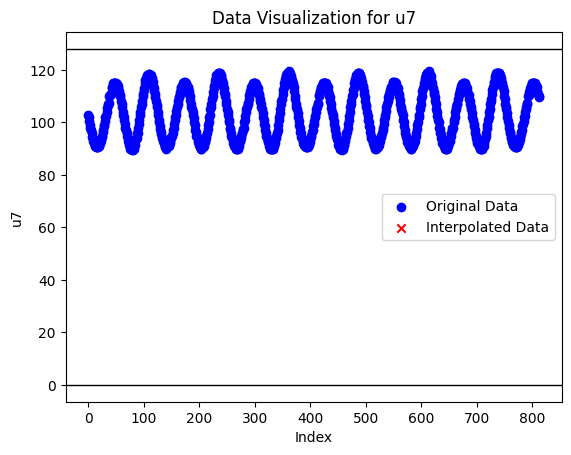

The number of NaN values in v7 before interpolation is 0
The number of NaN values in v7 after interpolation is 0
The number of NaN values in v7 after KNN imputation is 0


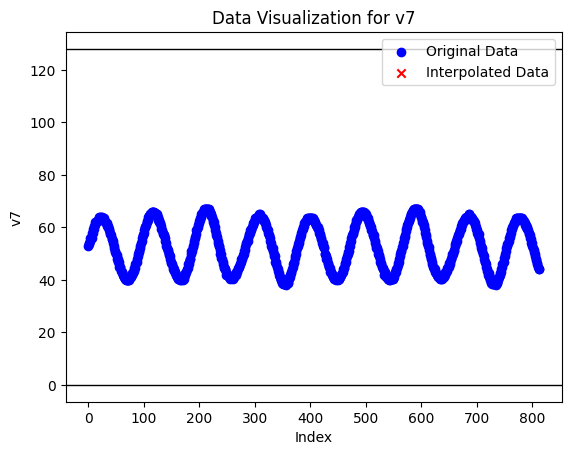

The number of NaN values in u8 before interpolation is 1
The number of NaN values in u8 after interpolation is 0
The number of NaN values in u8 after KNN imputation is 0


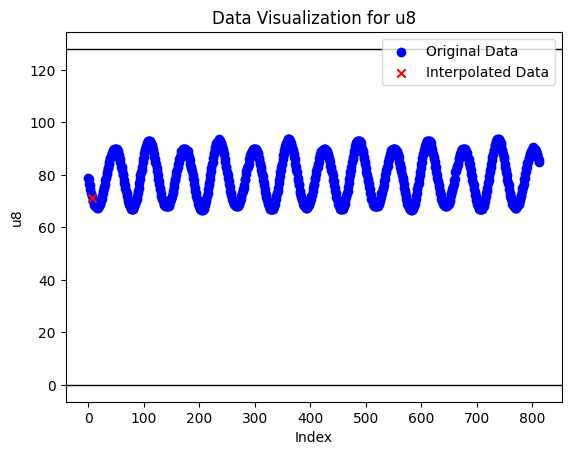

The number of NaN values in v8 before interpolation is 1
The number of NaN values in v8 after interpolation is 0
The number of NaN values in v8 after KNN imputation is 0


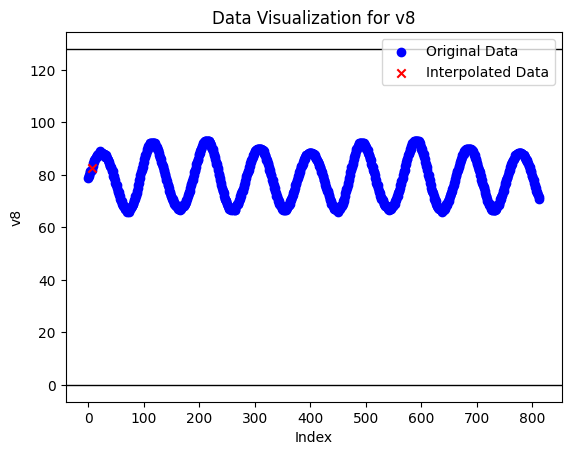

In [5]:
# Number of cameras
result_df = red_ball_data_to_interpolate.copy()
result_df_nan = result_df.isna()
new_data = pd.DataFrame()
# Loop through each pair of 'u' and 'v'
for col in red_ball_data_to_interpolate.columns:
    data = red_ball_data_to_interpolate[col].copy()
    original_indices = data.index
    original_values = data.values
    # get all the rows with NaN values
    data_nan = data[data.isna()]
    print(f'The number of NaN values in {col} before interpolation is {data.isna().sum()}')
    data = data.interpolate(method='polynomial', order=2)
    data_nan = data_nan.fillna(data)
    result_df_nan[col] = data_nan
    print(f'The number of NaN values in {col} after interpolation is {data.isna().sum()}')
    imputer_knn = KNNImputer(n_neighbors=2)
    data = data.values.reshape(-1, 1)
    data = imputer_knn.fit_transform(data)
    data = data.flatten()
    data = pd.DataFrame(data, columns=[col])
    # combine the original data with the interpolated data

    new_data = pd.concat([new_data, data], axis=1)
    print(f'The number of NaN values in {col} after KNN imputation is {data.isna().sum().values[0]}')
    plt.scatter(original_indices, original_values, color='blue', marker='o', label='Original Data')

    # Plot interpolated values in red crosses
    plt.scatter(data_nan.index, data_nan, color='red', marker='x', label='Interpolated Data')
    plt.axhline(y=128, color='black', linewidth=1)
    plt.axhline(y=0, color='black', linewidth=1)
    # Customize the plot
    plt.title(f'Data Visualization for {col}')
    plt.xlabel('Index')
    plt.ylabel(col)
    plt.legend()

    # Show the plot
    plt.show()

In [6]:
new_data

,u0,v0,u1,v1,u2,v2,u3,v3,u4,v4,u5,v5,u6,v6,u7,v7,u8,v8
0,16.0,52.5,79.0,53.5,16.0,66.0,60.5,66.0,103.5,66.0,16.0,80.0,103.0,79.5,103.0,53.0,79.0,79.0
1,15.0,53.0,78.5,53.5,14.0,67.0,59.0,67.0,102.0,67.0,15.0,81.0,102.0,80.0,102.0,53.5,78.5,79.5
2,13.0,54.0,77.0,55.0,13.0,68.0,58.0,68.0,100.0,68.0,13.0,82.0,100.5,81.5,100.5,54.0,76.5,80.0
3,12.0,54.0,76.0,55.0,11.5,69.0,56.0,68.0,99.0,68.0,12.0,83.0,99.0,81.5,99.0,55.0,76.0,81.0
4,10.0,55.0,75.0,56.0,10.5,69.0,56.0,69.5,98.0,69.0,10.0,83.0,98.0,82.0,98.0,56.0,74.5,81.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808,26.0,47.0,88.0,48.0,26.0,61.0,68.5,60.5,113.0,61.0,26.0,74.0,113.0,75.0,113.5,46.5,88.0,73.5
809,25.0,47.0,87.0,47.0,25.0,60.0,68.0,60.0,113.0,60.0,25.5,73.5,112.0,74.0,112.0,46.0,88.0,73.0
810,24.0,46.0,86.5,46.5,24.0,59.0,67.0,60.0,111.0,59.0,24.0,72.0,111.0,73.0,111.0,45.0,86.5,72.5
811,21.5,44.5,85.0,45.0,21.5,58.0,65.0,58.5,110.0,58.0,22.0,71.0,109.0,71.0,109.5,44.0,85.0,71.0


In [7]:
if save_output_file:
    new_data.to_csv(output_file, index=False, header=True)

#### Visualize the interpolated data

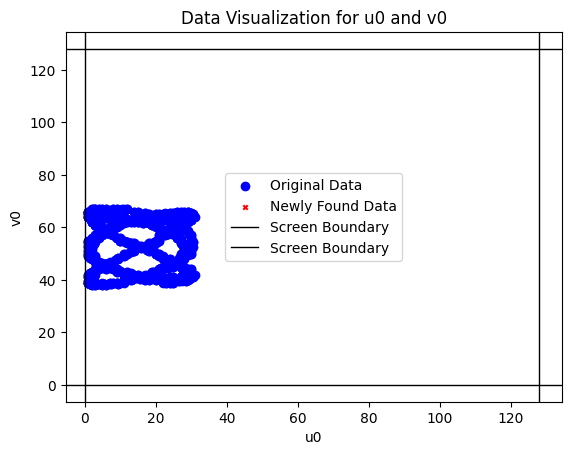

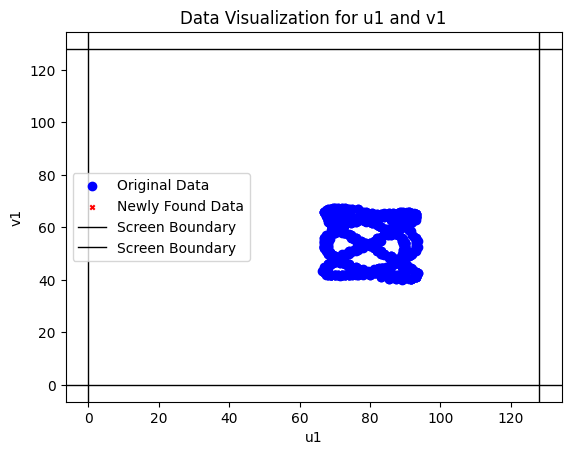

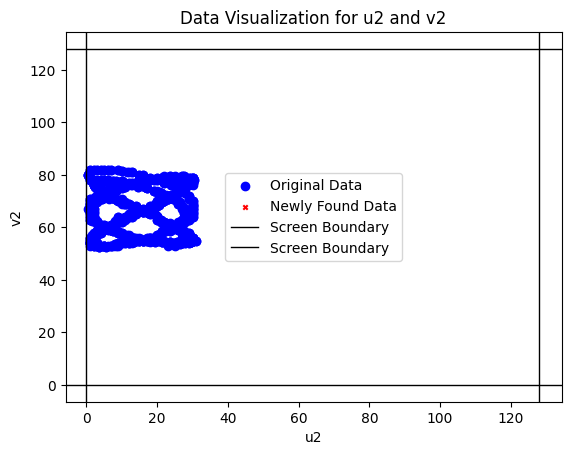

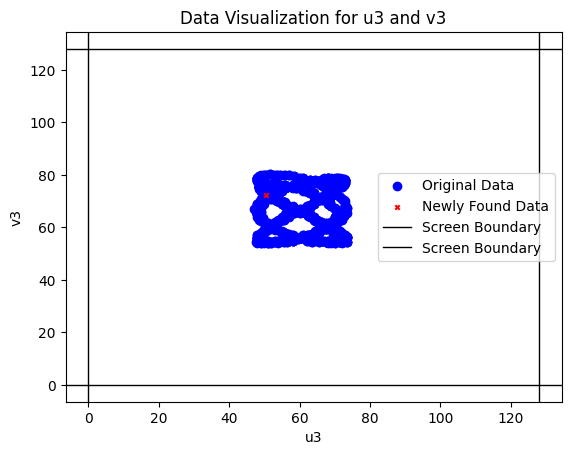

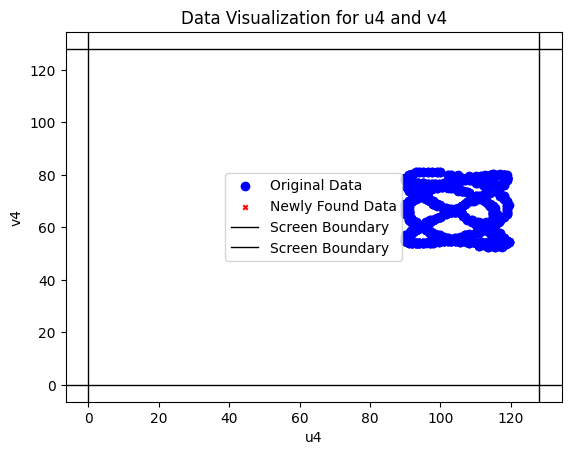

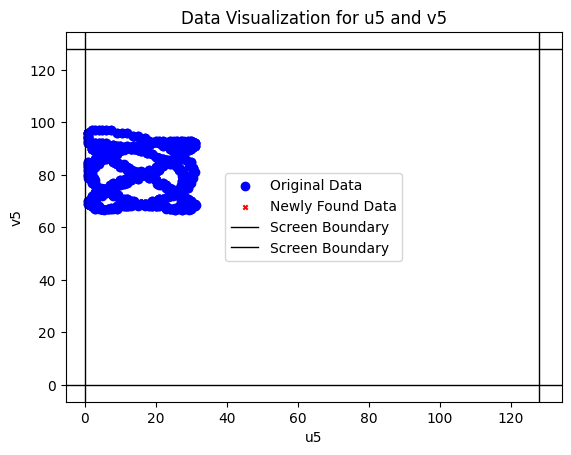

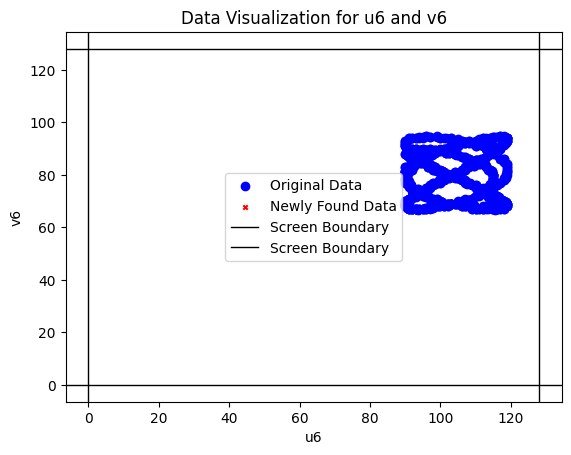

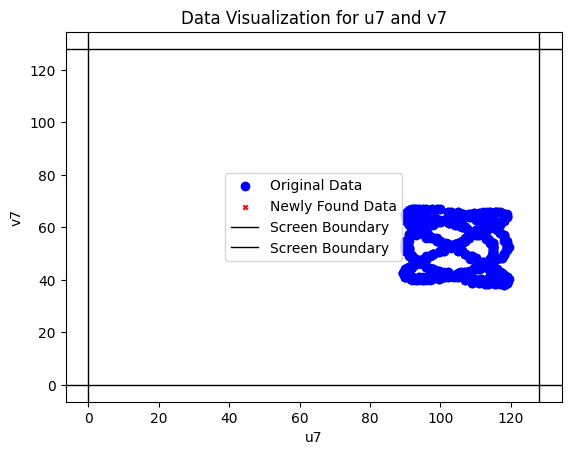

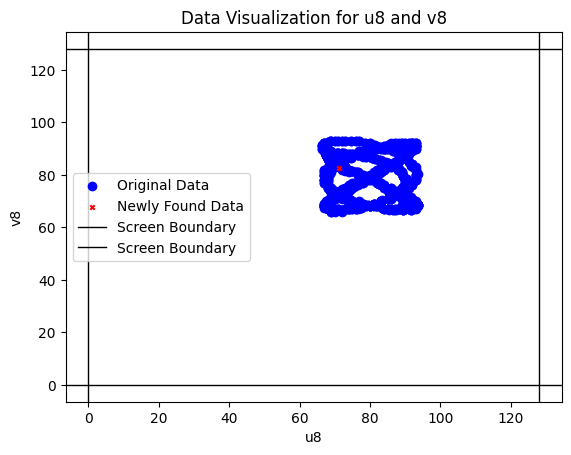

In [8]:
for i in range(num_cameras):
    col_u = f'u{i}'
    col_v = f'v{i}'
    
    # Plot original data in blue
    plt.scatter(result_df[col_u], result_df[col_v], color='blue', marker='o', label='Original Data')
    
    # Extract newly found values
    new_values_u = result_df_nan[col_u][result_df_nan[col_u].notna()]
    new_values_v = result_df_nan[col_v][result_df_nan[col_v].notna()]

    # Plot newly found values in red
    plt.scatter(new_values_u, new_values_v, color='red', marker='x', label='Newly Found Data', s=10)
    
    plt.axvline(x=128, color='black', linewidth=1, label='Screen Boundary')
    plt.axhline(y=128, color='black', linewidth=1)
    plt.axvline(x=0, color='black', linewidth=1, label='Screen Boundary')
    plt.axhline(y=0, color='black', linewidth=1)
    plt.title(f'Data Visualization for {col_u} and {col_v}')
    plt.xlabel(col_u)
    plt.ylabel(col_v)
    plt.legend()
    plt.show()
